In [15]:
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from power_prediction.baseline_model import plot_residuals
from power_prediction.util import split_data_train_test, make_column_names_model_safe
from power_prediction.load_dataset import load_data_residuals_remove_nan, load_data_default_remove_nan

# Random Forest with default Dataset

In [2]:
df = load_data_default_remove_nan()

Drop the "Date" and the "Date_format" column, since their features have been extracted into new columns

In [3]:
df_original = df.drop(["Date", "Date_format"], axis=1)

Make the column names safe for the model and split the test and training data with the custom split function, leaving the last year of data in the test set

In [4]:
df_original = make_column_names_model_safe(df_original)

In [5]:
train, test = split_data_train_test(df_original)

Since the custom test/train split does not shuffle the data, this is now done for the test data with a reproducible random state

In [6]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

Both training and test data are now split into X = predictors and Y = target

In [7]:
target_column = 'NE_tot'  # One of 'Value_NE5', 'Value_NE7', 'NE_tot'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p', 'Vacation', 'Holiday', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Corona']

In [8]:
X_train = train[predictor_columns]
y_train = train[target_column]
X_test = test[predictor_columns]
y_test = test[target_column]

### Model setup

For random forest regression, `XGBRFRegressor` from the `xgboost` python library is used.
The following parameters are available for hyperparemeter tuning.

- `n_estimators`: The number of decision trees the ensemble model includes
- `max_depth`: The maximum depth the tree is allowed to reach
- `learning_rate`: The strength of each tree's predictions in the ensemble
- `subsample`: The fraction of samples used for training each tree
- `colsample_bynode`: The fraction of features used for training each tree
- `reg_lambda`: L2 regularization term. Higher value makes model less likely to overfit
- `reg_alpha`: L1 regularization term. Higher value makes trees more sparse and more interpretable

In [9]:
hyperparameters = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "enable_categorical": True
}

In [10]:
model = XGBRFRegressor(**hyperparameters)

In [11]:
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.8, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0.0, ...)

In [12]:
y_pred = model.predict(X_test)

#### Model error evaluation

In [13]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  624205793.952
MAE:  21186.856
MAPE: 0.076
R2:   0.837



#### Residuals Plot

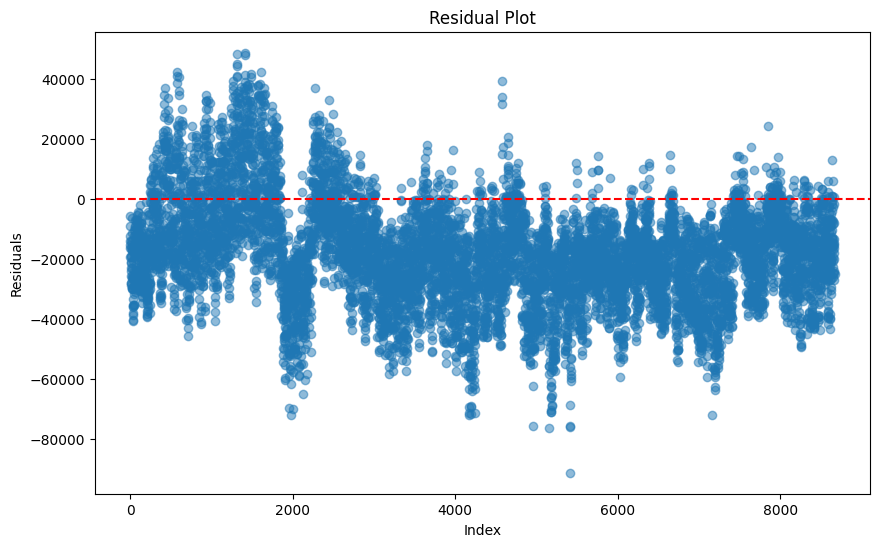

In [14]:
plot_residuals(y_test, y_pred)

# Hyperparameter tuning on default dataset

In [ ]:
model = XGBRFRegressor()

In [16]:
parameter_grid = {
    'random_state': [42],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0, 1.5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'enable_categorical': [True],
}

Create a grid search instance

In [17]:
grid_search = GridSearchCV(
    model, 
    param_grid=parameter_grid, 
    cv=5,                    
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [18]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=0.8, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      max_bin=None, max_cat_threshold=None,
                                      max_ca...
                                      n_jobs=None, num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      random_state=42, reg_alpha=0.0, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'enable_categorical': [True],
                         'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0, 1.5],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 200], 'random_state': [42],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [19]:
params = grid_search.best_params_  # or random_search.best_params_
model = grid_search.best_estimator_  # or random_search.best_estimator_
print("Best parameters found:", params)
print("Best model:", model)

Best parameters found: {'colsample_bytree': 1.0, 'enable_categorical': True, 'learning_rate': 1.0, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.7}
Best model: XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=1.0, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0.0, ...)


Predict with best found model

In [20]:
y_pred = model.predict(X_test)

#### Model error evaluation

In [21]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  729832059.216
MAE:  21522.433
MAPE: 0.072
R2:   0.809



#### Model residuals plot

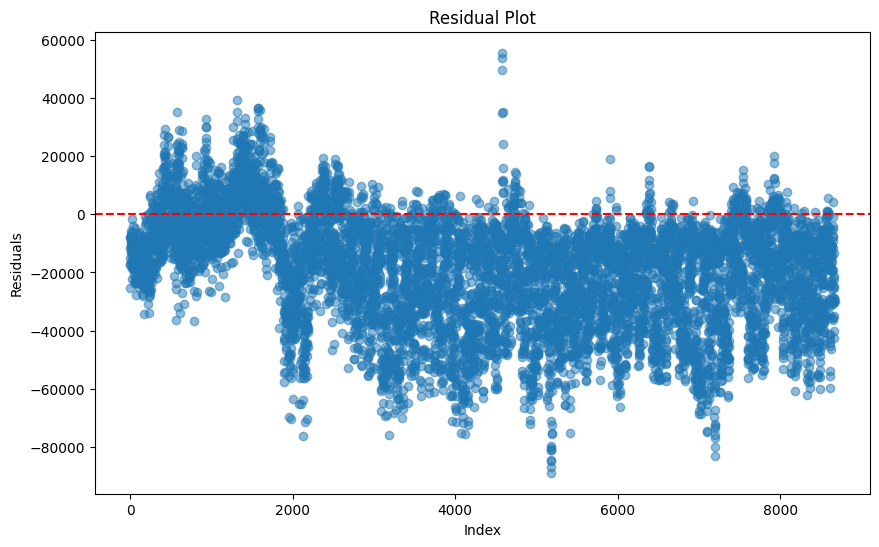

In [22]:
plot_residuals(y_test, y_pred)

# Random Forest with residuals Dataset

In [2]:
df = load_data_residuals_remove_nan()

Drop Date feature, because all time sensitivity has been eliminated with prophet

In [3]:
df_residuals = df.drop("Date", axis=1)

Remove the units from the column names and split data into training and test set with custom train/test split. test data is the last year of data

In [4]:
df_residuals = make_column_names_model_safe(df_residuals)

In [6]:
train, test = split_data_train_test(df_residuals)

Since the custom test/train split does not shuffle the data, this is now done for the test data with a reproducible random state

In [7]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)


Both training and test data are now split into X = predictors and Y = target

In [121]:
target_column = 'NETOT_remainder'  # One of 'NE5_remainder', 'NE7_remainder', 'NETOT_remainder'
predictor_columns = ['Hr', 'RainDur', 'StrGlo', 'T', 'WD', 'WVs', 'WVv', 'p']

In [122]:
X_train = train[predictor_columns]
y_train = train[target_column]
X_test = test[predictor_columns]
y_test = test[target_column]

### Model setup

For random forest regression, `XGBRFRegressor` from the `xgboost` python library is used.
The following parameters are available for hyperparemeter tuning.

- `n_estimators`: The number of decision trees the ensemble model includes
- `max_depth`: The maximum depth the tree is allowed to reach
- `learning_rate`: The strength of each tree's predictions in the ensemble
- `subsample`: The fraction of samples used for training each tree
- `colsample_bynode`: The fraction of features used for training each tree
- `reg_lambda`: L2 regularization term. Higher value makes model less likely to overfit
- `reg_alpha`: L1 regularization term. Higher value makes trees more sparse and more interpretable



In [123]:
hyperparameters = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
}

In [124]:
model = XGBRFRegressor(**hyperparameters)

In [125]:
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.8, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0.0, ...)

In [126]:
y_pred = model.predict(X_test)

#### Model error evaluation

In [127]:
print(
    f"MSE:  {mean_squared_error(y_test, y_pred):.3f}\n"
    f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}\n"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}\n"
    f"R2:   {r2_score(y_test, y_pred):.3f}\n"
)

MSE:  461345387.044
MAE:  16461.043
MAPE: 1.432
R2:   0.051



As it is clearly visible with an R2-Score of close to zero, the remaining variance in the data can barely be explained by the weather data alone.